# **Εργασία 5 - Node Embeddings**

Για την εργασία σας, θα χρησιμοποιήσετε τo Books about US Politics Dataset
(http://networkdata.ics.uci.edu/data/polbooks/).

Εφαρμόστε όλες τις μεθόδους στην μεγαλύτερη συνεκτική συνιστώσα του γράφου.

Παράγετε node embeddings (διανυσματικές αναπαραστάσεις) χρησιμοποιώντας:


*   Node2Vec με q=2 και p=1
*   Node2Vec με q=0.5 και p=1
*   Node2Vec με q=1 και p=1

Σε όλα τα πειράματα δώστε διάσταση embedding 64 (ή 32 αν το θεωρείτε καλύτερο).
Για τις υπόλοιπες παραμέτρους χρησιμοποιήστε είτε τις default τιμές, είτε προσαρμόστε τες όπως σας
εξυπηρετεί για καλύτερη ταχύτητα ή καλύτερα αποτελέσματα.
Σημείωση: Χρησιμοποιήστε τις ίδιες παραμέτρους σε όλες τις εκτελέσεις της μεθόδου.
Για να αποτιμήσετε την απόδοση των embeddings θα τα χρησιμοποιήσετε στα εξής προβλήματα:


1.   Link Prediction: Κάντε όποια μοντελοποίηση θέλετε και χρησιμοποιείστε όποιον κατηγοριοποιητή θέλετε. Μετρήστε accuracy/precision/recall.
2.   Clustering: Εφαρμόστε K-Means στα embeddings. Θεωρήστε Κ=3 και μετρήστε modularity, και purity. Χρησιμοποιήστε την μέθοδο t-SNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) για την οπτικοποίηση των διανυσματικών αναπαραστάσεων των κόμβων στις δύο διαστάσεις. Χρησιμοποιήστε την οπτικοποίηση για να συγκρίνετε τα αποτελέσματα του clustering με την πραγματική κατηγορία των κόμβων.

Παρουσιάστε και σχολιάστε τα αποτελέσματα σας.

In [3]:
!pip install node2vec

Libraries

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# Function to calculate true positives
def calculateTP(graph, communities, clustering):
    tp = 0
    for j in range(3):
        for i in (graph.nodes()):
            if (i in list(communities[j]) and i in clustering[j]):
                tp+=1
    return tp

In [6]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

Change file path if necessary

In [7]:
G1 = nx.read_gml("polbooks.gml", label="id")

In [8]:
ground_truth = nx.get_node_attributes(G1, 'value')
ground_truth_items = sorted(ground_truth.items())
ground_truth_dict = dict(ground_truth)
comm_gt = {}
for i, j in sorted(ground_truth.items()):
    comm_gt.setdefault(j, []).append(i)
communities_gt = [set(x) for x in comm_gt.values()]

Print communities

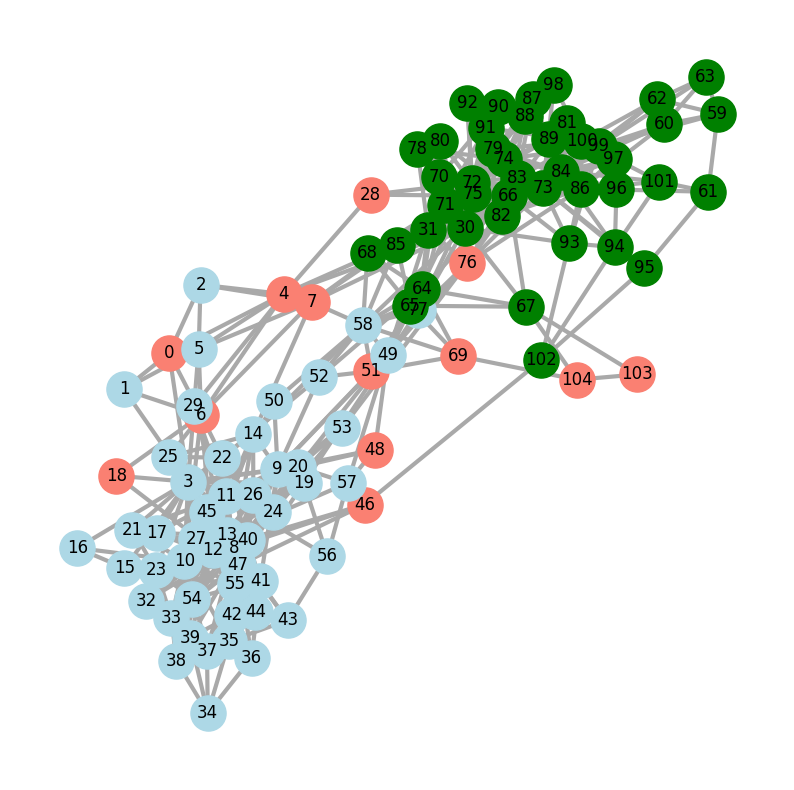

In [9]:
pos = nx.spring_layout(G1)
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G1, pos=pos, width=3, edge_color='darkgray')
colors = ['salmon', 'lightblue', 'green']
for community, color in zip(communities_gt, colors):
    nx.draw_networkx_nodes(G1, pos=pos, nodelist=community, node_color=color, node_size=640)
_ = plt.axis('off')
nx.draw_networkx_labels(G1, pos=pos)
plt.show()

## **Node2Vec #1**

### Clustering

In [10]:
node2vec_1 = Node2Vec(G1, dimensions=64, walk_length=60, num_walks=120, p=1, q=2)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 120/120 [00:03<00:00, 30.41it/s]


In [11]:
# Embed nodes
model1 = node2vec_1.fit(window=5, min_count=1)

In [12]:
# Save embeddings
model1.wv.save_word2vec_format("./model1.txt")

df1 = pd.read_csv('./model1.txt', sep='\s+', index_col=0, header=None, skiprows=1)

In [13]:
df1.index.name = 'node_ids'
# print(df1)

K-Means with k = 3

In [14]:
kmeans1 = KMeans(n_clusters=3)
kmeans1.fit(df1)
labels = kmeans1.predict(df1)
df1['cluster'] = labels
clusters_df1 = df1.reset_index()[['node_ids','cluster']]
print(clusters_df1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


     node_ids  cluster
0           8        2
1          12        2
2          84        0
3           3        2
4          72        0
..        ...      ...
100        18        2
101        92        0
102        28        0
103        50        1
104       103        1

[105 rows x 2 columns]


In [15]:
cluster_partition1=[[],[],[]]
for i in range(len(clusters_df1['cluster'])):
    if int(clusters_df1['cluster'][i]) == 0:
        cluster_partition1[0].append(int(clusters_df1['node_ids'][i]))
    elif int(clusters_df1['cluster'][i]) == 1:
        cluster_partition1[1].append(int(clusters_df1['node_ids'][i]))
    else:
        cluster_partition1[2].append(int(clusters_df1['node_ids'][i]))

# print(cluster_partition1)

Cluster Modularity

In [16]:
modularity_1 = nx.algorithms.community.modularity(G1, cluster_partition1)
print(f"Modularity = {modularity_1}")

Modularity = 0.5022650027509115


Cluster Purity

In [17]:
tp = calculateTP(G1, communities_gt, cluster_partition1)
purity_1 = 1-(tp/len(G1.nodes()))
print(f"Purity = {purity_1}")

Purity = 0.9523809523809523


Visualisations

In [18]:
# Retrieve node embeddings and corresponding subjects

# list of node IDs
node_ids = df1.index.tolist()

# numpy.ndarray of size number of nodes times embeddings dimensionality
node_embeddings = (model1.wv.vectors)

node_targets = [G1.nodes[int(node_id)]['value'] for node_id in node_ids]

In [19]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components = 2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

Text(0.5, 1.0, 'Node Embeddings')

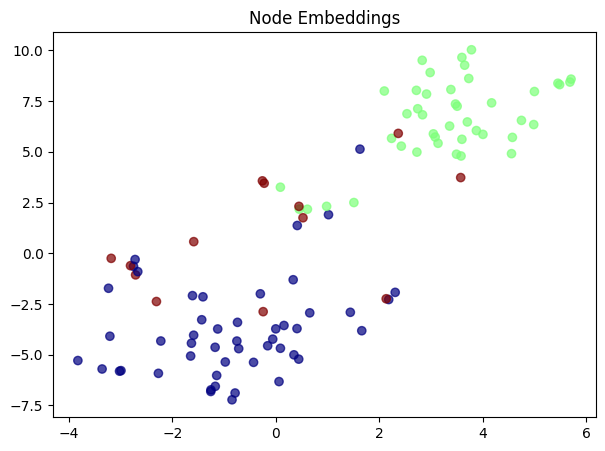

In [20]:
# Draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(7, 5))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("Node Embeddings")

Text(0.5, 1.0, 'Clustered Nodes')

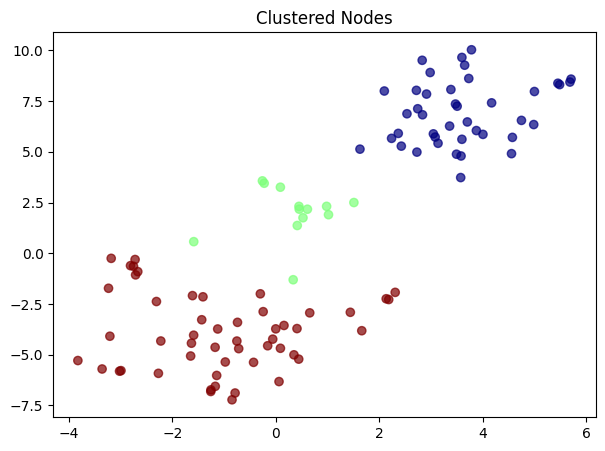

In [21]:
# Draw the original points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(df1['cluster']))}
node_colours = [label_map[target] for target in df1['cluster']]

plt.figure(figsize=(7, 5))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("Clustered Nodes")

*   Με διαφορετικό χρώμα μεν αλλά σαν κατηγοριοποίηση πολύ κοντά στα αρχικά δεδομένα η υλοποίηση με node2vec όπου q=2 και p=1. Το modularity είναι 0.5022650027509115 και το purity 95,24%.



### Link prediction

In [22]:
# Find all possible edges
unique_nodes = list(G1.nodes())
all_possible_edges = [(x,y) for (x,y) in product(unique_nodes, unique_nodes)]
len(all_possible_edges)

11025

In [23]:
edge_features = [(model1.wv.get_vector(str(i)) + model1.wv.get_vector(str(j))) for i,j in all_possible_edges]

In [24]:
edges = list(G1.edges())
is_connected = [1 if e in edges else 0 for e in all_possible_edges]
# sum(is_connected)

Train Model

In [25]:
# Get training and target data
X = np.array(edge_features)
y = is_connected

# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [26]:
# GBC classifier
clf = GradientBoostingClassifier()

# Train the model
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [27]:
y_true = y_test
y_pred = clf.predict(x_test)
x_pred = clf.predict(x_train)
train_acc = accuracy_score(y_train, x_pred)
test_acc = accuracy_score(y_test, y_pred)
print("Training Accuracy : ", train_acc)
print("Testing Accuracy : ", test_acc)

Training Accuracy :  0.9647531424128547
Testing Accuracy :  0.9455864570737605


In [28]:
print("MCC Score : ", matthews_corrcoef(y_true, y_pred))

MCC Score :  0.0018067864507225837


In [29]:
print("Test Classification Report : ")
print(classification_report(y_test, clf.predict(x_test)))

Test Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3168
           1       0.05      0.01      0.02       140

    accuracy                           0.95      3308
   macro avg       0.50      0.50      0.50      3308
weighted avg       0.92      0.95      0.93      3308



*   Ενώ παρουσιάζεται υψηλό accuracy, αυτό μπορεί να είναι παραπλανητικό. Αυτό οφείλεται στο γεγονός πως εάν το μοντέλο μας προβλέπει συνεχώς την κλάση που έχει τον μεγαλύτερο όγκο δεδομένων, τότε παρά το γεγονός ότι δεν θα προβλέπει ποτέ την άλλη κλάση θα έχουμε υψηλό σκορ ακρίβειας.

*   Ένας τρόπος αντιμετώπισης αυτού του φαινομένου είναι η χρήση της μετρικής Matthews Correlation Coefficient (MCC) ή αλλιώς rφ (Phi coefficient). Παίρνει τιμές από -1 έως 1. Τιμή ίση με 1 υποδεικνύει μια τέλεια πρόβλεψη, μια τιμή ίση με 0 μια μέση τυχαία πρόβλεψη και τιμή ίση με -1 μια πρόβλεψη με αποτελέσματα αντίστροφα της πραγματικότητας.

*   Στην περίπτωσή μας έχουμε MCC = 0.0018067864507225837 οπότε πρόκειται για μια τυχαία πρόβλεψη.

## **Node2Vec #2**

### Clustering

In [30]:
node2vec_2 = Node2Vec(G1, dimensions=64, walk_length=60, num_walks=120, p=1, q=0.5)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 120/120 [00:04<00:00, 26.41it/s]


In [31]:
# Embed nodes
model2 = node2vec_2.fit(window=5, min_count=1)

In [32]:
# Save embeddings
model2.wv.save_word2vec_format("./model2.txt")

df2 = pd.read_csv('./model2.txt', sep='\s+', index_col=0, header=None, skiprows=1)

In [33]:
df2.index.name = 'node_ids'
# print(df2)

K-Means with k = 3

In [34]:
kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(df2)
labels = kmeans2.predict(df2)
df2['cluster'] = labels
clusters_df2 = df2.reset_index()[['node_ids','cluster']]
print(clusters_df2)

     node_ids  cluster
0          12        1
1           3        1
2           8        1
3          72        0
4          84        0
..        ...      ...
100        28        0
101        18        1
102        16        1
103        92        0
104       103        2

[105 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
cluster_partition2=[[],[],[]]
for i in range(len(clusters_df2['cluster'])):
    if int(clusters_df2['cluster'][i]) == 0:
        cluster_partition2[0].append(int(clusters_df2['node_ids'][i]))
    elif int(clusters_df2['cluster'][i]) == 1:
        cluster_partition2[1].append(int(clusters_df2['node_ids'][i]))
    else:
        cluster_partition2[2].append(int(clusters_df2['node_ids'][i]))

# print(cluster_partition2)

Cluster Modularity

In [36]:
modularity_2 = nx.algorithms.community.modularity(G1, cluster_partition2)
print(f"Modularity = {modularity_2}")

Modularity = 0.49884050369959027


Cluster Purity

In [37]:
tp = calculateTP(G1, communities_gt, cluster_partition2)
purity_2 = 1-(tp/len(G1.nodes()))
print(f"Purity = {purity_2}")

Purity = 0.49523809523809526


Visualisations

In [38]:
# Retrieve node embeddings and corresponding subjects

# list of node IDs
node_ids = df2.index.tolist()

# numpy.ndarray of size number of nodes times embeddings dimensionality
node_embeddings = (model2.wv.vectors)

node_targets = [G1.nodes[int(node_id)]['value'] for node_id in node_ids]

In [39]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components = 2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

Text(0.5, 1.0, 'Node Embeddings')

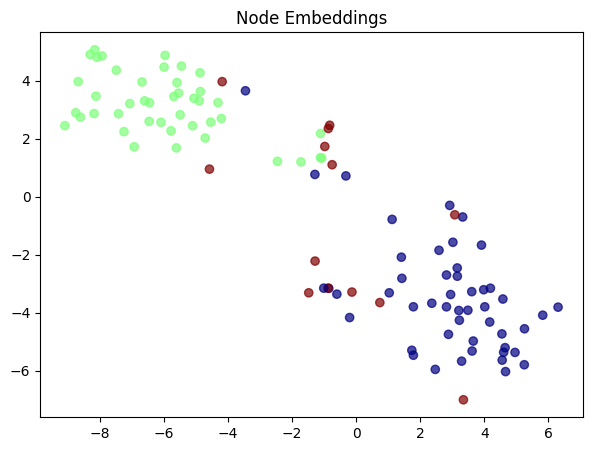

In [40]:
# Draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(7, 5))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("Node Embeddings")

Text(0.5, 1.0, 'Clustered Nodes')

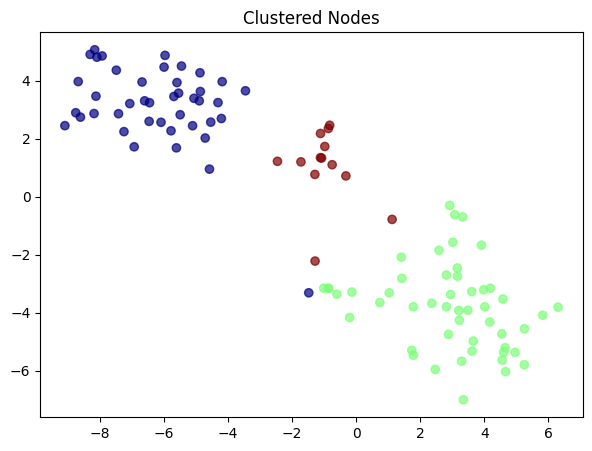

In [41]:
# Draw the original points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(df2['cluster']))}
node_colours = [label_map[target] for target in df2['cluster']]

plt.figure(figsize=(7, 5))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("Clustered Nodes")

*   Εδώ η κατηγοριοποίησή μας έχει σχετικά μέτρια αποτελέσματα για q=0.5 και p=1 καθώς το purity κυμαίνεται στο 49,52%. Από την άλλη έχουμε modularity = 0.49884050369959027.

### Link prediction

In [42]:
#Find all possible edges
unique_nodes = list(G1.nodes())
all_possible_edges = [(x,y) for (x,y) in product(unique_nodes, unique_nodes)]
len(all_possible_edges)

11025

In [43]:
edge_features = [(model2.wv.get_vector(str(i)) + model2.wv.get_vector(str(j))) for i,j in all_possible_edges]

In [44]:
edges = list(G1.edges())
is_connected = [1 if e in edges else 0 for e in all_possible_edges]
# sum(is_connected)

Train Model

In [45]:
# Get training and target data
X = np.array(edge_features)
y = is_connected

# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [46]:
# GBC classifier
clf = GradientBoostingClassifier()

# Train the model
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [47]:
y_true = y_test
y_pred = clf.predict(x_test)
x_pred = clf.predict(x_train)
train_acc = accuracy_score(y_train, x_pred)
test_acc = accuracy_score(y_test, y_pred)
print("Training Accuracy : ", train_acc)
print("Testing Accuracy : ", test_acc)

Training Accuracy :  0.962679797848905
Testing Accuracy :  0.9528415961305925


In [48]:
print("MCC Score : ", matthews_corrcoef(y_true, y_pred))

MCC Score :  -0.01950416470177455


In [49]:
print("Test Classification Report : ")
print(classification_report(y_test, clf.predict(x_test)))

Test Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3184
           1       0.00      0.00      0.00       124

    accuracy                           0.95      3308
   macro avg       0.48      0.49      0.49      3308
weighted avg       0.93      0.95      0.94      3308



*   Όπως πριν, σε αντίθεση με το υψηλό accuracy, παρατηρούμε μια πρόβλεψη ελάχιστα χειρότερη από την τύχη καθώς το MCC score βρίσκεται λίγο πιο κάτω από το 0.

## **Node2Vec #3**

### Clustering

In [50]:
node2vec_3 = Node2Vec(G1, dimensions=64, walk_length=60, num_walks=120, p=1, q=1)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 120/120 [00:04<00:00, 29.26it/s]


In [51]:
# Embed nodes
model3 = node2vec_3.fit(window=5, min_count=1)

In [52]:
# Save embeddings
model3.wv.save_word2vec_format("./model3.txt")

df3 = pd.read_csv('./model3.txt', sep='\s+', index_col=0, header=None, skiprows=1)

In [53]:
df3.index.name = 'node_ids'
# print(df3)

K-Means with k = 3

In [54]:
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(df3)
labels = kmeans3.predict(df3)
df3['cluster'] = labels
clusters_df3 = df3.reset_index()[['node_ids','cluster']]
print(clusters_df3)

     node_ids  cluster
0           8        0
1          12        0
2           3        0
3          84        2
4          72        2
..        ...      ...
100        16        0
101        18        0
102        50        1
103        92        2
104       103        1

[105 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [55]:
cluster_partition3=[[],[],[]]
for i in range(len(clusters_df3['cluster'])):
    if int(clusters_df3['cluster'][i]) == 0:
        cluster_partition3[0].append(int(clusters_df3['node_ids'][i]))
    elif int(clusters_df3['cluster'][i]) == 1:
        cluster_partition3[1].append(int(clusters_df3['node_ids'][i]))
    else:
        cluster_partition3[2].append(int(clusters_df3['node_ids'][i]))

# print(cluster_partition3)

Cluster Modularity

In [56]:
modularity_3 = nx.algorithms.community.modularity(G1, cluster_partition3)
print(f"Modularity = {modularity_3}")

Modularity = 0.502660928316905


Cluster Purity

In [57]:
tp = calculateTP(G1, communities_gt, cluster_partition3)
purity_3 = 1-(tp/len(G1.nodes()))
print(f"Purity = {purity_3}")

Purity = 0.5428571428571429


Visualisations

In [58]:
# Retrieve node embeddings and corresponding subjects

# list of node IDs
node_ids = df3.index.tolist()

# numpy.ndarray of size number of nodes times embeddings dimensionality
node_embeddings = (model3.wv.vectors)

node_targets = [G1.nodes[int(node_id)]['value'] for node_id in node_ids]

In [59]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components = 2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

Text(0.5, 1.0, 'Node Embeddings')

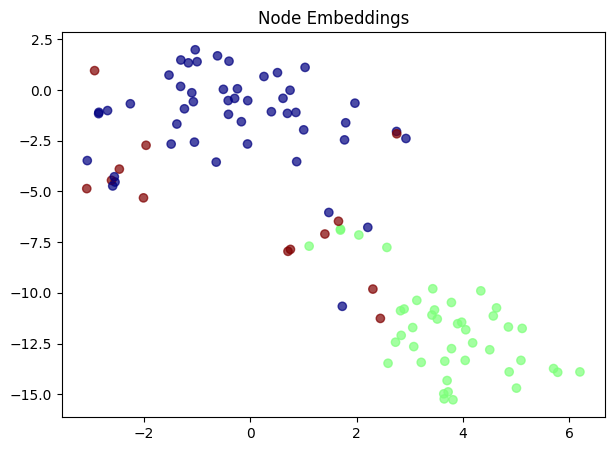

In [60]:
# Draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(7, 5))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("Node Embeddings")

Text(0.5, 1.0, 'Clustered Nodes')

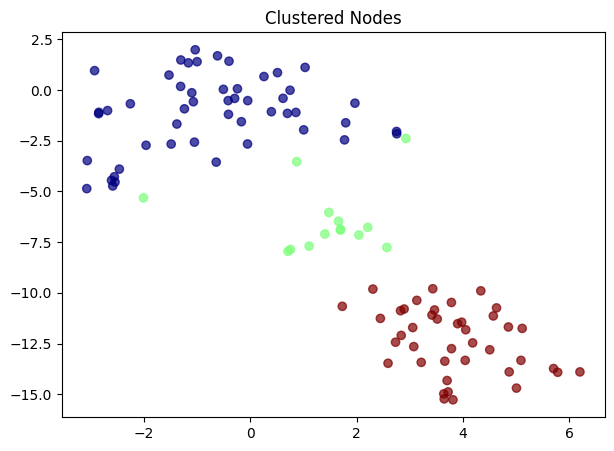

In [61]:
# Draw the original points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(df3['cluster']))}
node_colours = [label_map[target] for target in df3['cluster']]

plt.figure(figsize=(7, 5))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("Clustered Nodes")

*   Για την κατηγοριοποίηση με q = p = 1 το purity αγγίζει το 54,29% ενώ το modularity είναι ίσο με 0.502660928316905.


### Link prediction

In [62]:
# Find all possible edges
unique_nodes = list(G1.nodes())
all_possible_edges = [(x,y) for (x,y) in product(unique_nodes, unique_nodes)]
len(all_possible_edges)

11025

In [63]:
edge_features = [(model3.wv.get_vector(str(i)) + model3.wv.get_vector(str(j))) for i,j in all_possible_edges]

In [64]:
edges = list(G1.edges())
is_connected = [1 if e in edges else 0 for e in all_possible_edges]
# sum(is_connected)

Train Model

In [65]:
# Get training and target data
X = np.array(edge_features)
y = is_connected

# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [66]:
# GBC classifier
clf = GradientBoostingClassifier()

# Train the model
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [67]:
y_true = y_test
y_pred = clf.predict(x_test)
x_pred = clf.predict(x_train)
train_acc = accuracy_score(y_train, x_pred)
test_acc = accuracy_score(y_test, y_pred)
print("Training Accuracy : ", train_acc)
print("Testing Accuracy : ", test_acc)

Training Accuracy :  0.9659193987300765
Testing Accuracy :  0.9419588875453446


In [68]:
print("MCC Score : ", matthews_corrcoef(y_true, y_pred))

MCC Score :  -0.01403029426497188


In [69]:
print("Test Classification Report : ")
print(classification_report(y_test, clf.predict(x_test)))

Test Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3163
           1       0.02      0.01      0.01       145

    accuracy                           0.94      3308
   macro avg       0.49      0.50      0.49      3308
weighted avg       0.91      0.94      0.93      3308



*   Στα ίδια επίπεδα με τις άλλες 2 υλοποιήσεις, παρά το υψηλό accuracy η πρόβλεψή μας είναι ελάχιστα χειρότερη από την τύχη με MCC score = -0.01403029426497188.